# Character Segmentation Evaluation (Method 2)

Evaluate the adaptive threshold segmentation algorithm on all training data.

**Method**: Adaptive threshold + Otsu + Connected components + Smart merging/splitting

**Key features**:
- Dual thresholding for robustness
- Connected components for clean detection
- IoU-based merging for broken characters
- Vertical projection splitting for merged characters


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import Counter

# Paths
TRAIN_DIR = Path('dataset/train')
OUTPUT_IMG_DIR = Path('Segmented_dataset/train')
OUTPUT_LABEL_DIR = Path('Segmented_dataset/train2_labels')

OUTPUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_LABEL_DIR.mkdir(parents=True, exist_ok=True)

train_images = sorted(list(TRAIN_DIR.glob('*.png')))
print(f"Found {len(train_images)} training images")
print(f"Segmented images will be saved to: {OUTPUT_IMG_DIR}")
print(f"Label txt files will be saved to: {OUTPUT_LABEL_DIR}")


Found 0 training images
Segmented images will be saved to: Segmented_dataset\train
Label txt files will be saved to: Segmented_dataset\train2_labels


In [6]:
def merge_overlapping_boxes(boxes, iou_thresh=0.15, gap_thresh=2):
    """Merge overlapping or very close bounding boxes"""
    if not boxes:
        return []
    
    boxes = sorted(boxes, key=lambda b: b[0])
    merged = []
    
    for box in boxes:
        x, y, w, h = box
        merged_flag = False
        
        for i, (mx, my, mw, mh) in enumerate(merged):
            # Calculate IoU
            ix1, iy1 = max(x, mx), max(y, my)
            ix2, iy2 = min(x + w, mx + mw), min(y + h, my + mh)
            iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
            intersection = iw * ih
            union = w * h + mw * mh - intersection
            iou = intersection / union if union > 0 else 0
            
            # Calculate horizontal gap
            horiz_gap = max(0, max(mx, x) - min(mx + mw, x + w))
            size_ratio = min(w, mw) / max(w, mw) * min(h, mh) / max(h, mh)
            
            # Merge if overlapping or very close with similar size
            if (iou > iou_thresh or horiz_gap <= gap_thresh) and size_ratio > 0.5:
                nx = min(x, mx)
                ny = min(y, my)
                nw = max(x + w, mx + mw) - nx
                nh = max(y + h, my + mh) - ny
                merged[i] = (nx, ny, nw, nh)
                merged_flag = True
                break
        
        if not merged_flag:
            merged.append(box)
    
    return merged

def split_wide_box(img, x, y, w, h, threshold=40):
    """Split wide boxes that may contain multiple characters"""
    sub_img = img[y:y+h, x:x+w]
    gray = cv2.cvtColor(sub_img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    projection = np.sum(binary, axis=0)
    
    # Find split points (vertical gaps)
    split_points = []
    for i in range(1, len(projection)):
        if projection[i-1] > 0 and projection[i] == 0:
            split_points.append(i)
    
    # Create boxes between split points
    boxes = []
    prev = 0
    for sp in split_points + [w]:
        if sp - prev > 5:
            boxes.append((x + prev, y, sp - prev, h))
        prev = sp
    
    return boxes if len(boxes) > 1 else [(x, y, w, h)]

def segment_characters(img_path):
    """Method 2: Adaptive threshold + connected components + smart merging"""
    img = cv2.imread(str(img_path))
    if img is None:
        return 0, []
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Enhance low contrast images
    contrast = np.std(gray)
    if contrast < 25:
        b, g, r = cv2.split(img)
        gray = cv2.max(b, cv2.max(g, r))
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    
    # Histogram equalization and gamma correction
    gray = cv2.equalizeHist(gray)
    gray = np.power(gray / 255.0, 0.8)
    gray = np.uint8(gray * 255)
    
    # Dual thresholding: Adaptive + Otsu
    thresh1 = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 15
    )
    _, thresh2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh = cv2.bitwise_or(thresh1, thresh2)
    
    # Morphological cleaning
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Connected components analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean)
    
    # Extract character bounding boxes with size filtering
    char_boxes = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if 40 < area < 2000 and 10 < h < img.shape[0] * 0.9 and w > 3:
            char_boxes.append((x, y, w, h))
    
    # Merge overlapping boxes (handles broken characters)
    char_boxes = merge_overlapping_boxes(char_boxes)
    char_boxes = sorted(char_boxes, key=lambda b: b[0])
    
    # Split wide boxes (handles merged characters)
    final_boxes = []
    for (x, y, w, h) in char_boxes:
        if w > 40:  # Wide box likely contains multiple characters
            split_boxes = split_wide_box(img, x, y, w, h)
            final_boxes.extend(split_boxes)
        else:
            final_boxes.append((x, y, w, h))
    
    return len(final_boxes), final_boxes

print("Method 2 segmentation function defined")


Method 2 segmentation function defined


## Process All Images and Save with Bounding Boxes


In [33]:
# Process all images
results = []
correct_count = 0

print("Processing and saving segmented images and labels...")
for img_path in tqdm(train_images, desc="Segmenting"):
    filename = img_path.name
    label = filename.split('-')[0]
    expected = len(label)
    
    # Segment
    detected, boxes = segment_characters(img_path)
    is_correct = (detected == expected)
    if is_correct:
        correct_count += 1
    
    # Read original image for saving and coordinate conversion
    img = cv2.imread(str(img_path))
    img_height, img_width = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw bounding boxes on image
    for (x, y, w, h) in boxes:
        color = (0, 255, 0) if is_correct else (255, 0, 0)
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), color, 2)
    
    # Save image with bounding boxes
    output_img_path = OUTPUT_IMG_DIR / filename
    cv2.imwrite(str(output_img_path), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    
    # Save coordinates in YOLO format (same as train_labels)
    txt_filename = filename.replace('.png', '.txt')
    output_txt_path = OUTPUT_LABEL_DIR / txt_filename
    
    with open(output_txt_path, 'w') as f:
        for (x, y, w, h) in boxes:
            # Convert to YOLO format: class x_center y_center width height (normalized)
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            width_norm = w / img_width
            height_norm = h / img_height
            
            # Class 0 for all (we don't know the actual character class)
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
    
    results.append({
        'filename': filename,
        'label': label,
        'expected': expected,
        'detected': detected,
        'correct': is_correct
    })

total = len(results)
accuracy = (correct_count / total * 100) if total > 0 else 0

print(f"\nCompleted!")
print(f"Total: {total} | Correct: {correct_count} | Accuracy: {accuracy:.2f}%")
print(f"Segmented images saved to: {OUTPUT_IMG_DIR}")
print(f"Label txt files saved to: {OUTPUT_LABEL_DIR}")


Processing and saving segmented images and labels...


Segmenting: 100%|██████████| 7764/7764 [00:28<00:00, 271.33it/s]


Completed!
Total: 7764 | Correct: 6237 | Accuracy: 80.33%
Segmented images saved to: Segmented_dataset\train
Label txt files saved to: Segmented_dataset\train2_labels


## Error Analysis


In [34]:
# Detection difference distribution
detection_diff = Counter(r['detected'] - r['expected'] for r in results)

print("Detection Difference Distribution:")
print("="*50)
for diff in sorted(detection_diff.keys()):
    count = detection_diff[diff]
    pct = count / total * 100
    if diff == 0:
        print(f"Perfect match: {count} ({pct:.1f}%)")
    elif diff > 0:
        print(f"Over-segmented (+{diff}): {count} ({pct:.1f}%)")
    else:
        print(f"Under-segmented ({diff}): {count} ({pct:.1f}%)")


Detection Difference Distribution:
Under-segmented (-8): 12 (0.2%)
Under-segmented (-7): 25 (0.3%)
Under-segmented (-6): 34 (0.4%)
Under-segmented (-5): 54 (0.7%)
Under-segmented (-4): 104 (1.3%)
Under-segmented (-3): 170 (2.2%)
Under-segmented (-2): 300 (3.9%)
Under-segmented (-1): 644 (8.3%)
Perfect match: 6237 (80.3%)
Over-segmented (+1): 100 (1.3%)
Over-segmented (+2): 39 (0.5%)
Over-segmented (+3): 22 (0.3%)
Over-segmented (+4): 13 (0.2%)
Over-segmented (+5): 4 (0.1%)
Over-segmented (+6): 3 (0.0%)
Over-segmented (+8): 3 (0.0%)


## Visualization


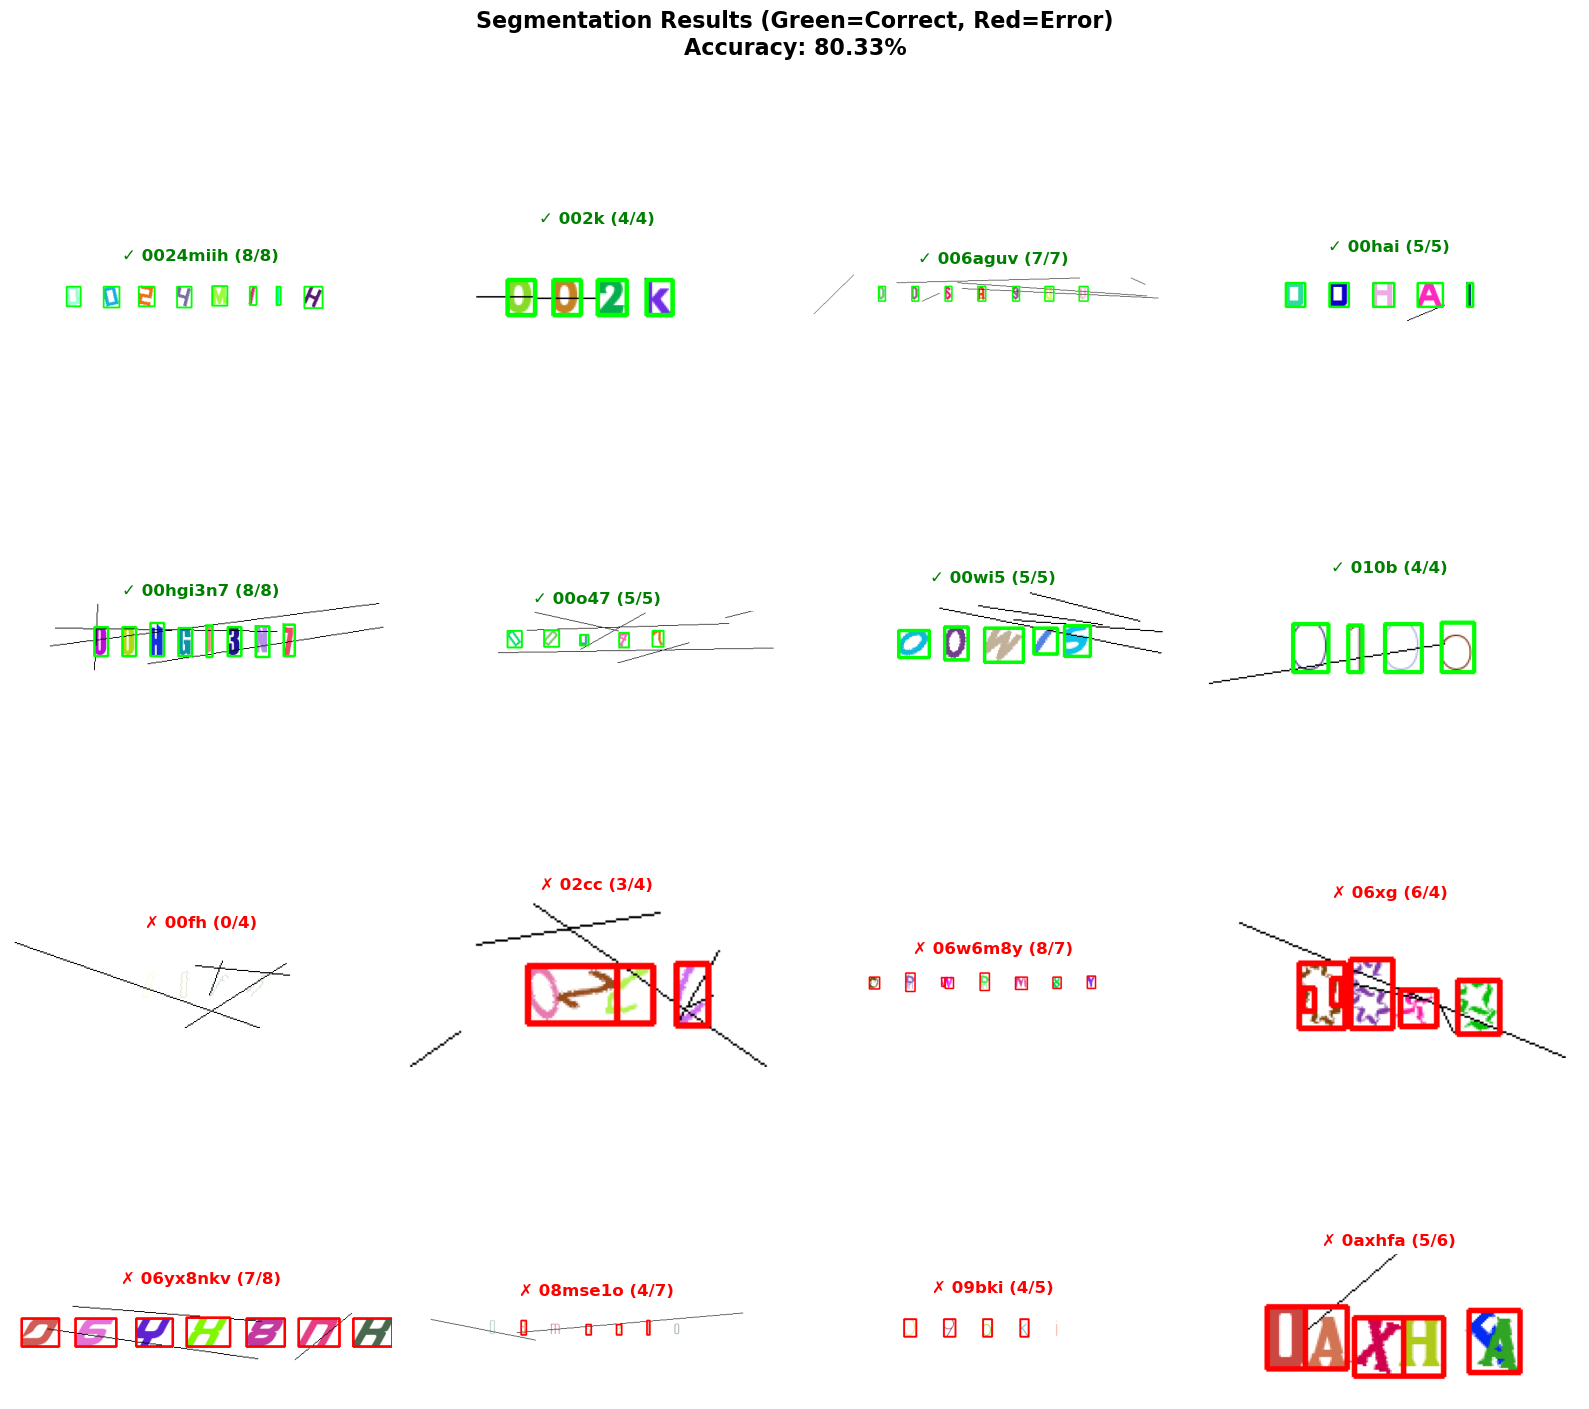

In [35]:
# Show sample results
correct_samples = [r for r in results if r['correct']][:8]
error_samples = [r for r in results if not r['correct']][:8]

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Correct examples
for i in range(8):
    if i < len(correct_samples):
        r = correct_samples[i]
        img = cv2.imread(str(OUTPUT_IMG_DIR / r['filename']))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i//4, i%4].imshow(img_rgb)
        axes[i//4, i%4].set_title(f"✓ {r['label']} ({r['detected']}/{r['expected']})", 
                                  color='green', fontweight='bold')
    axes[i//4, i%4].axis('off')

# Error examples  
for i in range(8):
    if i < len(error_samples):
        r = error_samples[i]
        img = cv2.imread(str(OUTPUT_IMG_DIR / r['filename']))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[2+i//4, i%4].imshow(img_rgb)
        axes[2+i//4, i%4].set_title(f"✗ {r['label']} ({r['detected']}/{r['expected']})", 
                                   color='red', fontweight='bold')
    axes[2+i//4, i%4].axis('off')

plt.suptitle(f'Segmentation Results (Green=Correct, Red=Error)\nAccuracy: {accuracy:.2f}%', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


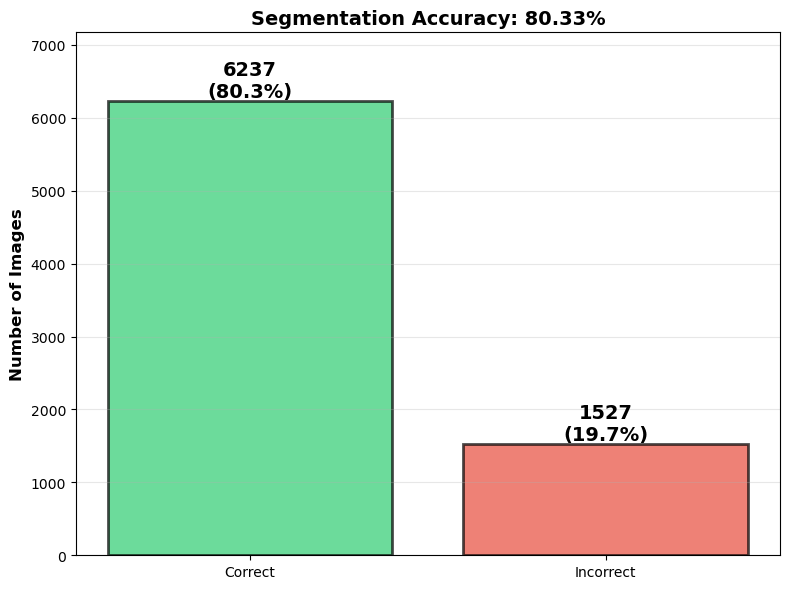


SUMMARY: 6237/7764 correct (80.33%)
Images with bounding boxes saved to: Segmented_dataset\train


In [36]:
# Accuracy chart
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Correct', 'Incorrect']
counts = [correct_count, total - correct_count]
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({count/total*100:.1f}%)',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title(f'Segmentation Accuracy: {accuracy:.2f}%', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(counts) * 1.15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print(f"SUMMARY: {correct_count}/{total} correct ({accuracy:.2f}%)")
print(f"Images with bounding boxes saved to: {OUTPUT_DIR}")
print(f"{'='*50}")


## Compare with Original Labels

Compare train2_labels (generated) with train_labels (ground truth):


In [37]:
# Compare train_labels (ground truth) with train2_labels (generated)
GROUND_TRUTH_DIR = Path('Segmented_dataset/train_labels')
GENERATED_DIR = Path('Segmented_dataset/train2_labels')

def read_label_file(file_path):
    """Read label file and return list of bounding boxes"""
    if not file_path.exists():
        return None
    
    boxes = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:  # Skip empty lines
                parts = line.split()
                if len(parts) == 5:
                    boxes.append(tuple(map(float, parts[1:])))  # Skip class, keep coordinates
    return boxes

def boxes_match(boxes1, boxes2, tolerance=0.02):
    """Check if two sets of boxes match (with tolerance for small differences)"""
    if boxes1 is None or boxes2 is None:
        return False
    
    if len(boxes1) != len(boxes2):
        return False
    
    # Sort boxes by x coordinate for comparison
    boxes1_sorted = sorted(boxes1, key=lambda b: b[0])
    boxes2_sorted = sorted(boxes2, key=lambda b: b[0])
    
    # Check if all boxes match within tolerance
    for b1, b2 in zip(boxes1_sorted, boxes2_sorted):
        for v1, v2 in zip(b1, b2):
            if abs(v1 - v2) > tolerance:
                return False
    return True

# Compare all files
print("Comparing label files...")
total_files = 0
matching_files = 0
different_files = 0
missing_files = 0
different_count_files = 0

comparison_details = []

for gt_file in sorted(GROUND_TRUTH_DIR.glob('*.txt')):
    filename = gt_file.name
    gen_file = GENERATED_DIR / filename
    
    total_files += 1
    
    gt_boxes = read_label_file(gt_file)
    gen_boxes = read_label_file(gen_file)
    
    if gen_boxes is None:
        missing_files += 1
        comparison_details.append({
            'filename': filename,
            'status': 'missing',
            'gt_count': len(gt_boxes) if gt_boxes else 0,
            'gen_count': 0
        })
    elif boxes_match(gt_boxes, gen_boxes):
        matching_files += 1
        comparison_details.append({
            'filename': filename,
            'status': 'match',
            'gt_count': len(gt_boxes),
            'gen_count': len(gen_boxes)
        })
    else:
        different_files += 1
        gt_count = len(gt_boxes) if gt_boxes else 0
        gen_count = len(gen_boxes) if gen_boxes else 0
        
        if gt_count != gen_count:
            different_count_files += 1
        
        comparison_details.append({
            'filename': filename,
            'status': 'different',
            'gt_count': gt_count,
            'gen_count': gen_count
        })

# Calculate percentages
match_percentage = (matching_files / total_files * 100) if total_files > 0 else 0
different_percentage = (different_files / total_files * 100) if total_files > 0 else 0

print("\n" + "="*60)
print("LABEL COMPARISON RESULTS")
print("="*60)
print(f"Total files compared: {total_files}")
print(f"Matching files: {matching_files} ({match_percentage:.2f}%)")
print(f"Different files: {different_files} ({different_percentage:.2f}%)")
print(f"  - Different box count: {different_count_files}")
print(f"  - Different coordinates: {different_files - different_count_files}")
print(f"Missing files: {missing_files}")
print("="*60)


Comparing label files...

LABEL COMPARISON RESULTS
Total files compared: 7764
Matching files: 6237 (80.33%)
Different files: 1527 (19.67%)
  - Different box count: 1511
  - Different coordinates: 16
Missing files: 0


## Process Test Data

Apply segmentation to test images and save results:


In [10]:
# Setup paths for test data
TEST_DIR = Path('../dataset/test')
OUTPUT_TEST_IMG_DIR = Path('../Segmented_dataset/test')
OUTPUT_TEST_LABEL_DIR = Path('../Segmented_dataset/test_labels')

OUTPUT_TEST_IMG_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_TEST_LABEL_DIR.mkdir(parents=True, exist_ok=True)

test_images = sorted(list(TEST_DIR.glob('*.png')))
print(f"Found {len(test_images)} test images")
print(f"Images will be saved to: {OUTPUT_TEST_IMG_DIR}")
print(f"Labels will be saved to: {OUTPUT_TEST_LABEL_DIR}")


Found 1943 test images
Images will be saved to: ..\Segmented_dataset\test
Labels will be saved to: ..\Segmented_dataset\test_labels


In [11]:
# Process all test images
test_results = []
test_correct_count = 0

print("Processing and saving segmented images and labels...")
for img_path in tqdm(test_images, desc="Segmenting"):
    filename = img_path.name
    label = filename.split('-')[0]
    expected = len(label)
    
    # Segment
    detected, boxes = segment_characters(img_path)
    is_correct = (detected == expected)
    if is_correct:
        test_correct_count += 1
    
    # Read original image for saving and coordinate conversion
    img = cv2.imread(str(img_path))
    img_height, img_width = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw bounding boxes on image
    for (x, y, w, h) in boxes:
        color = (0, 255, 0) if is_correct else (255, 0, 0)
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), color, 2)
    
    # Save image with bounding boxes
    output_img_path = OUTPUT_TEST_IMG_DIR / filename
    cv2.imwrite(str(output_img_path), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    
    # Save coordinates in YOLO format (same as train_labels)
    txt_filename = filename.replace('.png', '.txt')
    output_txt_path = OUTPUT_TEST_LABEL_DIR / txt_filename
    
    with open(output_txt_path, 'w') as f:
        for (x, y, w, h) in boxes:
            # Convert to YOLO format: class x_center y_center width height (normalized)
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            width_norm = w / img_width
            height_norm = h / img_height
            
            # Class 0 for all (we don't know the actual character class)
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
    
    test_results.append({
        'filename': filename,
        'label': label,
        'expected': expected,
        'detected': detected,
        'correct': is_correct
    })

test_total = len(test_results)
test_accuracy = (test_correct_count / test_total * 100) if test_total > 0 else 0

print(f"\nCompleted!")
print(f"Total: {test_total} | Correct: {test_correct_count} | Accuracy: {test_accuracy:.2f}%")
print(f"Segmented images saved to: {OUTPUT_TEST_IMG_DIR}")
print(f"Label txt files saved to: {OUTPUT_TEST_LABEL_DIR}")


Processing and saving segmented images and labels...


Segmenting: 100%|██████████| 1943/1943 [00:07<00:00, 269.55it/s]


Completed!
Total: 1943 | Correct: 1558 | Accuracy: 80.19%
Segmented images saved to: ..\Segmented_dataset\test
Label txt files saved to: ..\Segmented_dataset\test_labels


In [13]:
# Detection difference distribution
test_detection_diff = Counter(r['detected'] - r['expected'] for r in test_results)

print("Detection Difference Distribution:")
print("="*50)
for diff in sorted(test_detection_diff.keys()):
    count = test_detection_diff[diff]
    pct = count / test_total * 100
    if diff == 0:
        print(f"Perfect match: {count} ({pct:.1f}%)")
    elif diff > 0:
        print(f"Over-segmented (+{diff}): {count} ({pct:.1f}%)")
    else:
        print(f"Under-segmented ({diff}): {count} ({pct:.1f}%)")


Detection Difference Distribution:
Under-segmented (-8): 3 (0.2%)
Under-segmented (-7): 6 (0.3%)
Under-segmented (-6): 11 (0.6%)
Under-segmented (-5): 21 (1.1%)
Under-segmented (-4): 21 (1.1%)
Under-segmented (-3): 43 (2.2%)
Under-segmented (-2): 81 (4.2%)
Under-segmented (-1): 161 (8.3%)
Perfect match: 1558 (80.2%)
Over-segmented (+1): 20 (1.0%)
Over-segmented (+2): 10 (0.5%)
Over-segmented (+3): 2 (0.1%)
Over-segmented (+4): 2 (0.1%)
Over-segmented (+5): 2 (0.1%)
Over-segmented (+8): 1 (0.1%)
Over-segmented (+9): 1 (0.1%)


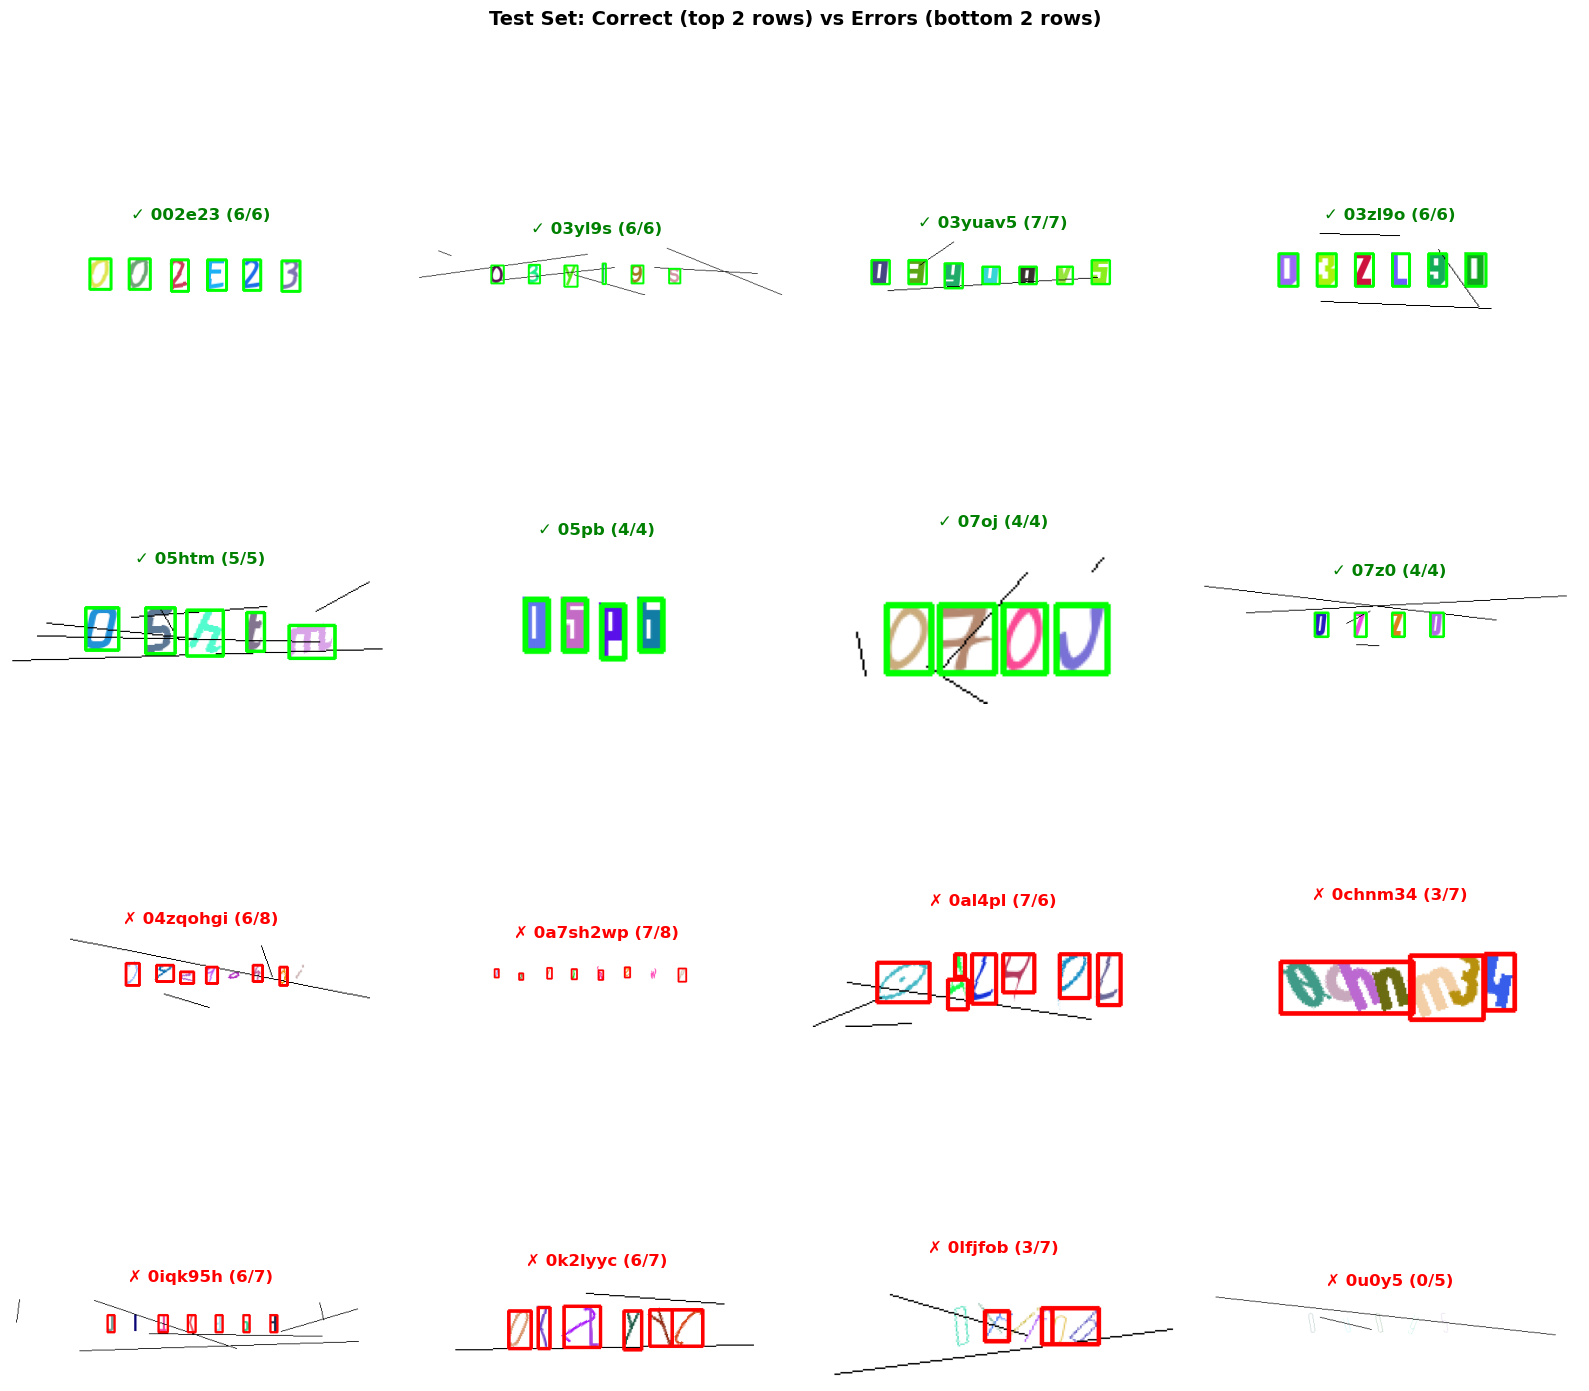

In [14]:
# Show sample results
test_correct_samples = [r for r in test_results if r['correct']][:8]
test_error_samples = [r for r in test_results if not r['correct']][:8]

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Correct examples
for i in range(8):
    if i < len(test_correct_samples):
        r = test_correct_samples[i]
        img = cv2.imread(str(OUTPUT_TEST_IMG_DIR / r['filename']))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i//4, i%4].imshow(img_rgb)
        axes[i//4, i%4].set_title(f"✓ {r['label']} ({r['detected']}/{r['expected']})", 
                                  color='green', fontweight='bold')
    axes[i//4, i%4].axis('off')

# Error examples  
for i in range(8):
    if i < len(test_error_samples):
        r = test_error_samples[i]
        img = cv2.imread(str(OUTPUT_TEST_IMG_DIR / r['filename']))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i//4+2, i%4].imshow(img_rgb)
        axes[i//4+2, i%4].set_title(f"✗ {r['label']} ({r['detected']}/{r['expected']})", 
                                    color='red', fontweight='bold')
    axes[i//4+2, i%4].axis('off')

plt.suptitle('Test Set: Correct (top 2 rows) vs Errors (bottom 2 rows)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
